# Phase Identification NN

Developement of a neural network capable of identifying the phase of a 2D system (liquid, hexatic or solid)

In [3]:
import tensorflow as tf

import glob
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2023-01-13 00:54:08.854590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 00:54:09.174525: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-13 00:54:09.228314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 00:54:09.228349: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

2.11.0


## Load data

First, let us load the data

In [4]:
# loop over all the runs
train_data = []
train_labels = []

path = 'ordered_128/Pe0'
conf_counter = 0


for fi in glob.glob(path + '/fi*'):
    # extract the density from the path name
    #print(fi)
    density, run = tuple(fi.split('/')[2].split('_'))
    density = float(density.split('fi')[1])
    print(density, run)
    # loop over all the trajectories
    phase_label = 0 # liquid
    if density > 0.705:
        phase_label = 1
    if density > 0.725:
        phase_label = 2
    #print(phase_label)
    
    for j, trj in enumerate(glob.glob(fi + '/Trj/xyz.dump.*')):
        if j>20:
            break
        # load the trajectory
        #print(phase_label, trj)
        data = np.loadtxt(trj, skiprows=9)
        
        xmax = np.max(data[:,1])
        ymax = np.max(data[:,2])

        data[:,1] = data[:,1] / xmax
        data[:,2] = data[:,2] / ymax

        train_data.append(data[:,[1,2]])
        train_labels.append(phase_label)

        conf_counter += 1
    
    if conf_counter >= 1500:
        break

print(conf_counter)

0.708 8
0.722 7
0.702 6
0.732 1
0.704 8
0.729 1
0.704 6
0.706 8
0.7 6
0.724 8
0.72 1
0.712 7
0.716 8
0.714 8
0.718 8
0.712 8
0.72 8
0.736 1
0.702 7
0.71 1
0.712 6
0.714 6
0.72 6
0.72 7
0.735 1
0.738 1
0.708 7
0.716 7
0.722 8
0.715 1
0.704 7
0.722 6
0.726 6
0.724 7
0.737 1
0.7 7
0.723 1
0.724 6
0.73 1
0.705 1
0.706 7
0.726 1
0.733 1
0.727 1
0.718 7
0.7 8
0.731 1
0.71 7
0.708 6
0.718 6
0.71 8
0.71 6
0.728 1
0.714 7
0.706 6
0.702 8
0.739 1
0.74 1
0.724 1
0.726 7
0.734 1
0.725 1
0.726 8
0.716 6
1259


In [5]:
# loop over all the runs
test_data = []
test_labels = []

path = 'ordered_128/Pe0'
test_counter = 0

for i, fi in enumerate(glob.glob(path + '/fi*')):
    if i < 15:
        continue

    # extract the density from the path name
    #print(fi)
    density, run = tuple(fi.split('/')[2].split('_'))
    density = float(density.split('fi')[1])
    print(density, run)
    # loop over all the trajectories
    phase_label = 0 # liquid
    if density > 0.705:
        phase_label = 1
    if density > 0.725:
        phase_label = 2
    #print(phase_label)
    
    for j, trj in enumerate(glob.glob(fi + '/Trj/xyz.dump.*')):
        if j > 10:
            break
        # load the trajectory
        #print(phase_label, trj)
        data = np.loadtxt(trj, skiprows=9)
        
        xmax = np.max(data[:,1])
        ymax = np.max(data[:,2])

        data[:,1] = data[:,1] / xmax
        data[:,2] = data[:,2] / ymax

        test_data.append(data[:,[1,2]])
        test_labels.append(phase_label)

        test_counter += 1
    
    if test_counter >= 500:
        break

0.712 8
0.72 8
0.736 1
0.702 7
0.71 1
0.712 6
0.714 6
0.72 6
0.72 7
0.735 1
0.738 1
0.708 7
0.716 7
0.722 8
0.715 1
0.704 7
0.722 6
0.726 6
0.724 7
0.737 1
0.7 7
0.723 1
0.724 6
0.73 1
0.705 1
0.706 7
0.726 1
0.733 1
0.727 1
0.718 7
0.7 8
0.731 1
0.71 7
0.708 6
0.718 6
0.71 8
0.71 6
0.728 1
0.714 7
0.706 6
0.702 8
0.739 1
0.74 1
0.724 1
0.726 7
0.734 1


In [6]:
print(test_counter)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

506


## Data selection


In [7]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

print(train_data.shape)
print(train_labels.shape)

(1259, 16384, 2)
(1259,)


[[0.73116102 0.97770978]
 [0.98406532 0.87208305]
 [0.07215987 0.79156818]
 ...
 [0.99054451 0.95805895]
 [0.93476149 0.88559644]
 [0.13102701 0.19516683]]


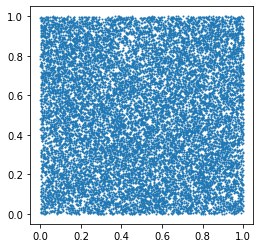

In [9]:
print(train_data[0])

plt.figure(figsize=(4,4))
#plt.xticks([])
#plt.yticks([])
plt.plot(train_data[-1][:,0], train_data[0][:,1], 'o', markersize=1)
plt.show()


## Set the model

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(16384,2)),
    tf.keras.layers.Dense(2048, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(3)
])

In [27]:
from keras.optimizers import SGD
#opt = SGD(lr=0.000001)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
model.fit(train_data, train_labels, epochs=10)

Epoch 1/10
40/40 [==============================] - 18s 424ms/step - loss: 10.7857 - accuracy: 0.1668
Epoch 2/10
40/40 [==============================] - 18s 449ms/step - loss: 10.6674 - accuracy: 0.1668
Epoch 3/10
40/40 [==============================] - 18s 446ms/step - loss: 10.6674 - accuracy: 0.1668
Epoch 4/10
40/40 [==============================] - 18s 445ms/step - loss: 10.6674 - accuracy: 0.1668
Epoch 5/10
40/40 [==============================] - 19s 478ms/step - loss: 10.6674 - accuracy: 0.1668
Epoch 6/10
40/40 [==============================] - 18s 448ms/step - loss: 10.6674 - accuracy: 0.1668
Epoch 7/10
40/40 [==============================] - 19s 472ms/step - loss: 10.6674 - accuracy: 0.1668
Epoch 8/10
40/40 [==============================] - 18s 453ms/step - loss: 10.6674 - accuracy: 0.1668
Epoch 9/10
40/40 [==============================] - 17s 432ms/step - loss: 10.6674 - accuracy: 0.1668
Epoch 10/10
40/40 [==============================] - 18s 443ms/step - loss: 10.667

In [31]:
model.evaluate(test_data, test_labels)

16/16 [==============================] - 0s 10ms/step - loss: -386.0356 - accuracy: 0.6087


[-386.03558349609375, 0.6086956262588501]

In [27]:
predictions = model.predict(test_data)

20/20 [==============================] - 0s 11ms/step


In [28]:
predictions[0]

array([1.], dtype=float32)